In [2]:
import warnings
warnings.filterwarnings('ignore')  # To ignore warnings

import numpy as np
from scipy.stats import norm

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


from nltk.corpus import stopwords

import string
import re

from bs4 import BeautifulSoup

# For stemming and lemmatization
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Importing vectorizers for text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# For pretty-printing tabular data
from tabulate import tabulate

# Importing Yellowbrick visualization tools
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Importing clustering evaluation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Installing yellowbrick library (uncomment if not installed)
# !pip install yellowbrick

# For Cross-Validation and Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Importing clustering algorithms
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.decomposition import LatentDirichletAllocation


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
df=pd.read_csv(r"/content/healthcare-dataset-stroke-data.csv")

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [7]:
df.shape
print(f'Dataset having {df.shape[0]} rows and {df.shape[1]} columns')

Dataset having 5110 rows and 12 columns


In [8]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [10]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [11]:
df.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [12]:
# Checking duplicated values in dataset
count_duplicated = df.duplicated().sum()
print(f'Dataset having {count_duplicated} duplicated values')

Dataset having 0 duplicated values


In [13]:
# Checking for number of null values in dataset
count_null_df=pd.DataFrame({'columns':df.columns,'number_of_nulls_values':df.isna().sum()})
count_null_df.set_index('columns').sort_values(by='number_of_nulls_values', ascending = False)

,number_of_nulls_values
columns,
bmi,201
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0


In [14]:
# Variables/Columns of dataset
columns=list(df.columns)
print(columns)

['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [15]:
# Basic description of all Dataset
df.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


In [16]:
# Finding Categorical variables
categorical_variables=[var for var in df.describe(include='object')]
print(f'Dataset having {len(categorical_variables)} categorical variables')
print('~~'*45)
print(categorical_variables)


Dataset having 5 categorical variables
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [17]:
# Finding numerical variables
numerical_variables=[var for var in df.columns if var not in categorical_variables]
print(f'Dataset having {len(numerical_variables)} numerical variables')
print('~~'*45)
print(numerical_variables)

Dataset having 7 numerical variables
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


In [18]:
# Unique Values and its frequency for each variable
for var in df.columns:
    print(f'Feature Name : {var}\n')
    category=df[var].value_counts()
    print(category)
    print('~~'*45)

Feature Name : id

id
9046     1
22194    1
15104    1
28315    1
56996    1
        ..
897      1
4789     1
5686     1
37451    1
44679    1
Name: count, Length: 5110, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Feature Name : gender

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Feature Name : age

age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: count, Length: 104, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Feature Name : hypertension

hypertension
0    4612
1     498
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Feature Name : heart_disease

heart_disease
0    4834
1   

In [19]:
# Checking duplicated values in dataset
count_duplicated = df.duplicated().sum()
print(f'Dataset having {count_duplicated} duplicated values')

Dataset having 0 duplicated values


In [20]:
# Checking for number of null values
null_df=pd.DataFrame({'columns':df.columns,'number_of_nulls_values':df.isna().sum(),'percentage_null_values':round(df.isna().sum()*100/len(df),2)})
null_df.set_index('columns').sort_values(by='percentage_null_values', ascending = False)

,number_of_nulls_values,percentage_null_values
columns,,
bmi,201,3.93
id,0,0.00
gender,0,0.00
age,0,0.00
hypertension,0,0.00
heart_disease,0,0.00
ever_married,0,0.00
work_type,0,0.00
Residence_type,0,0.00


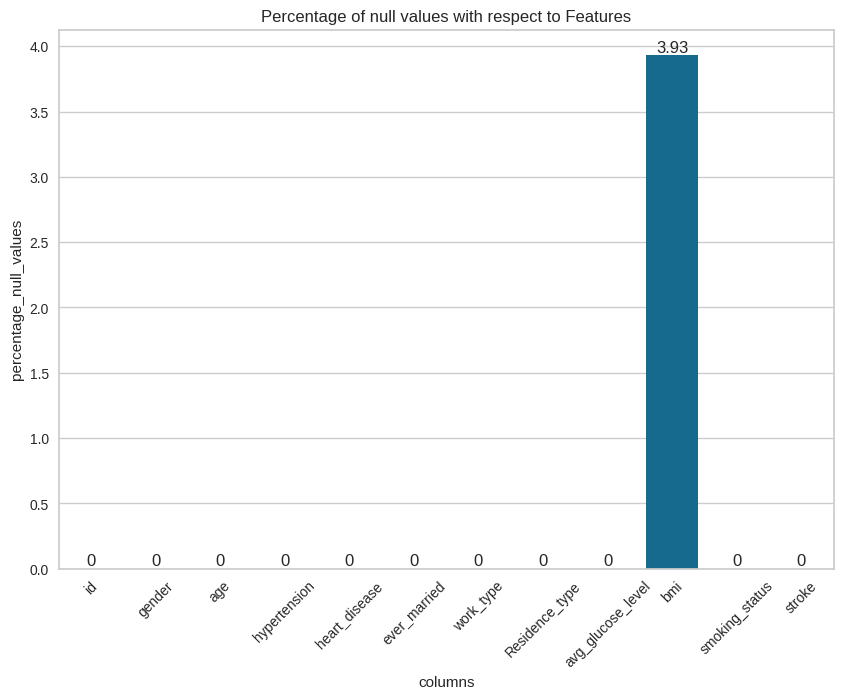

In [21]:
# Ploting number of null values with its variable
plt.figure(figsize=(10,7))
ax=sns.barplot(x='columns', y='percentage_null_values', data=null_df)
ax.bar_label(ax.containers[0])
plt.title('Percentage of null values with respect to Features')
plt.xticks(rotation= 45)
plt.show()

Text(0.5, 1.0, 'Missing values in the dataset with respect to its features')

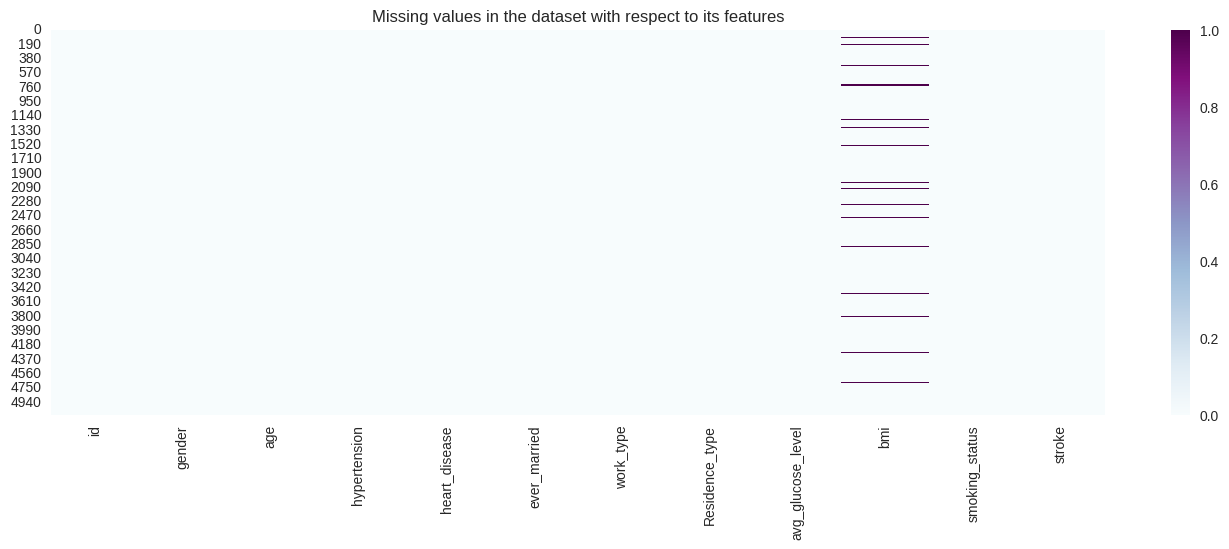

In [22]:
# Vizualizing the null values from the dataset
plt.figure(figsize=(17,5))
sns.heatmap(df.isnull(),cbar=True, cmap='BuPu')
plt.title('Missing values in the dataset with respect to its features')

In [23]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [24]:
# Nullfree shape of dataset
df.shape

(5110, 12)

__________________________________________________________________________________________


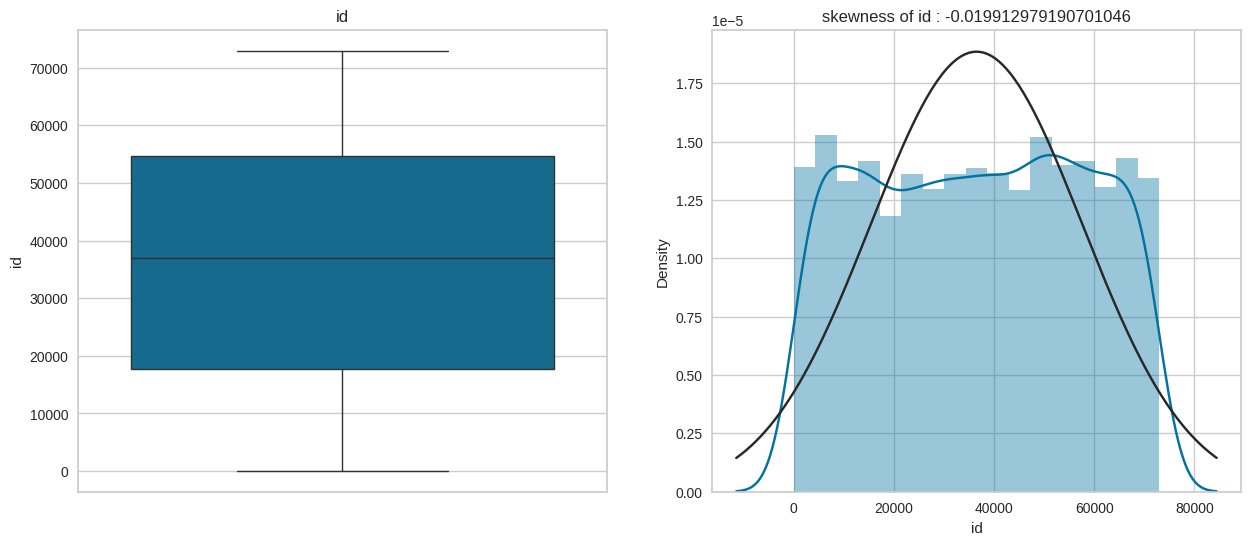

__________________________________________________________________________________________
__________________________________________________________________________________________


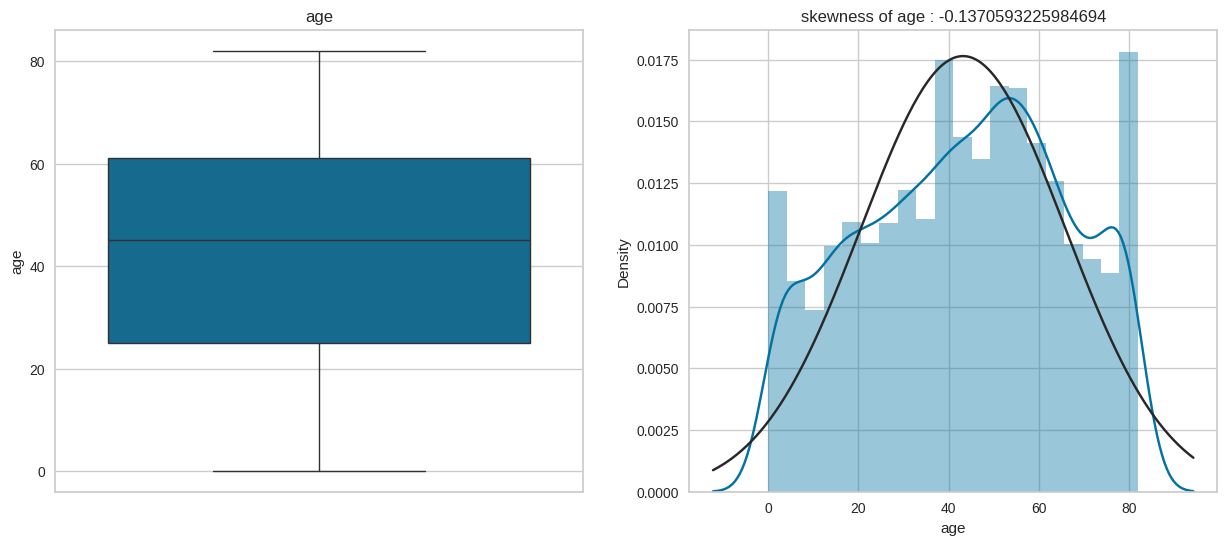

__________________________________________________________________________________________
__________________________________________________________________________________________


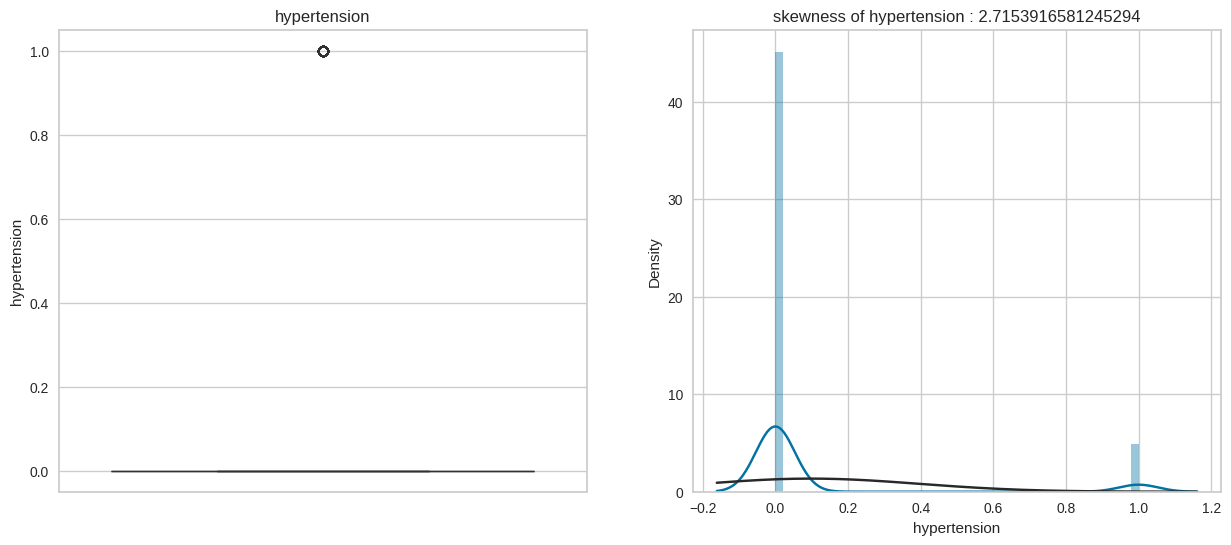

__________________________________________________________________________________________
__________________________________________________________________________________________


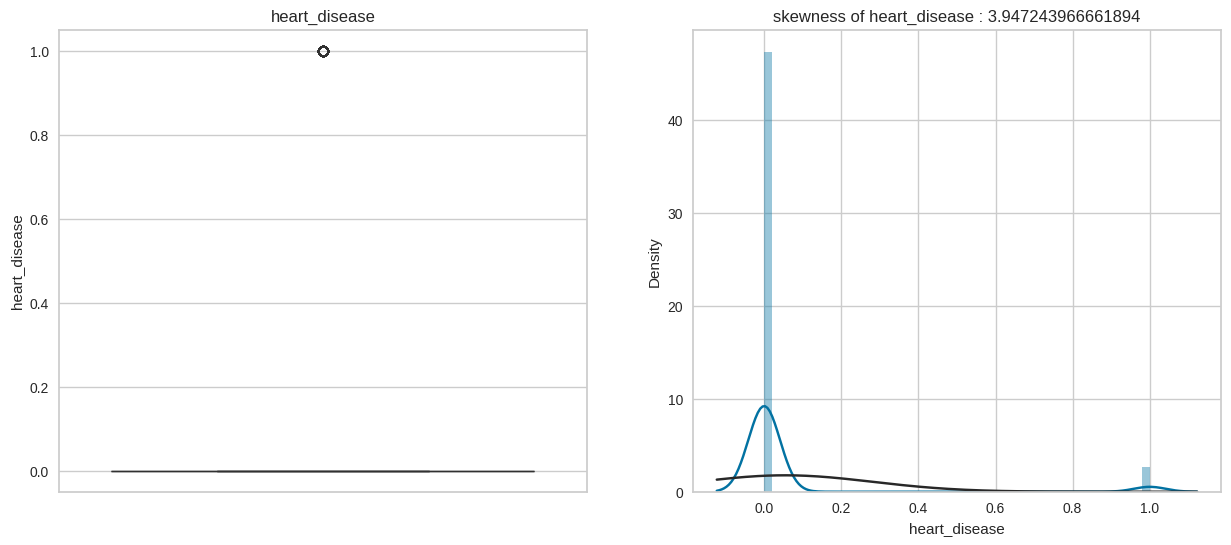

__________________________________________________________________________________________
__________________________________________________________________________________________


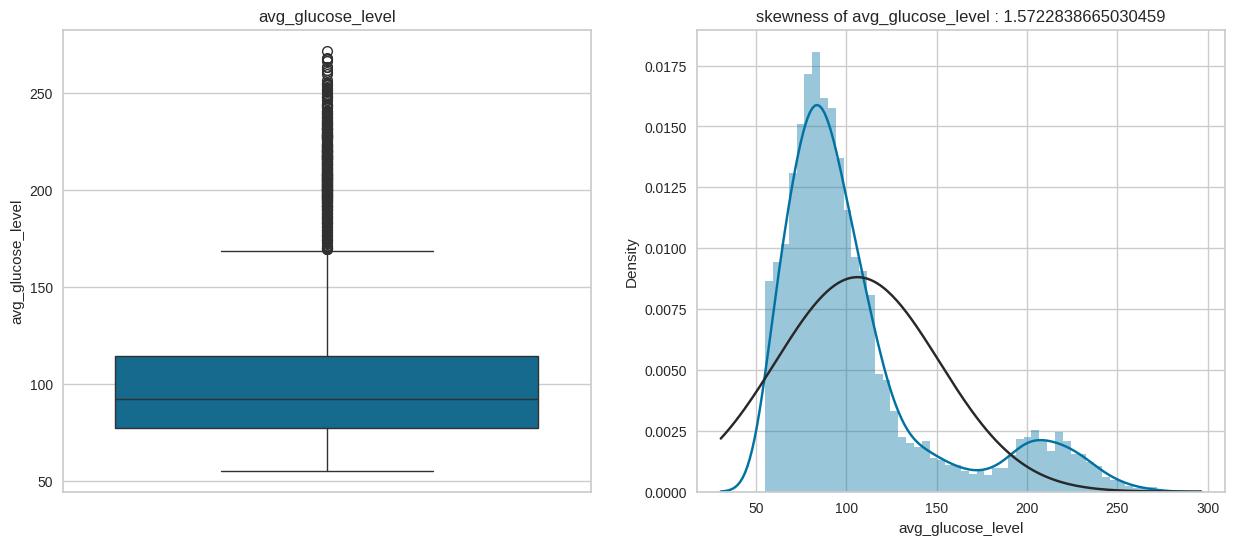

__________________________________________________________________________________________
__________________________________________________________________________________________


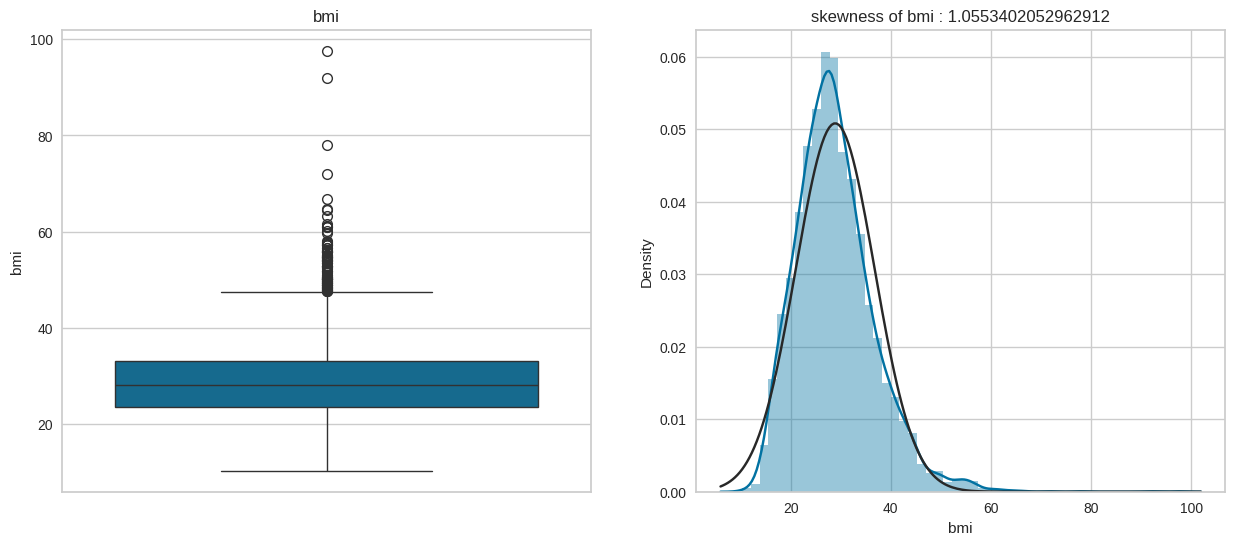

__________________________________________________________________________________________
__________________________________________________________________________________________


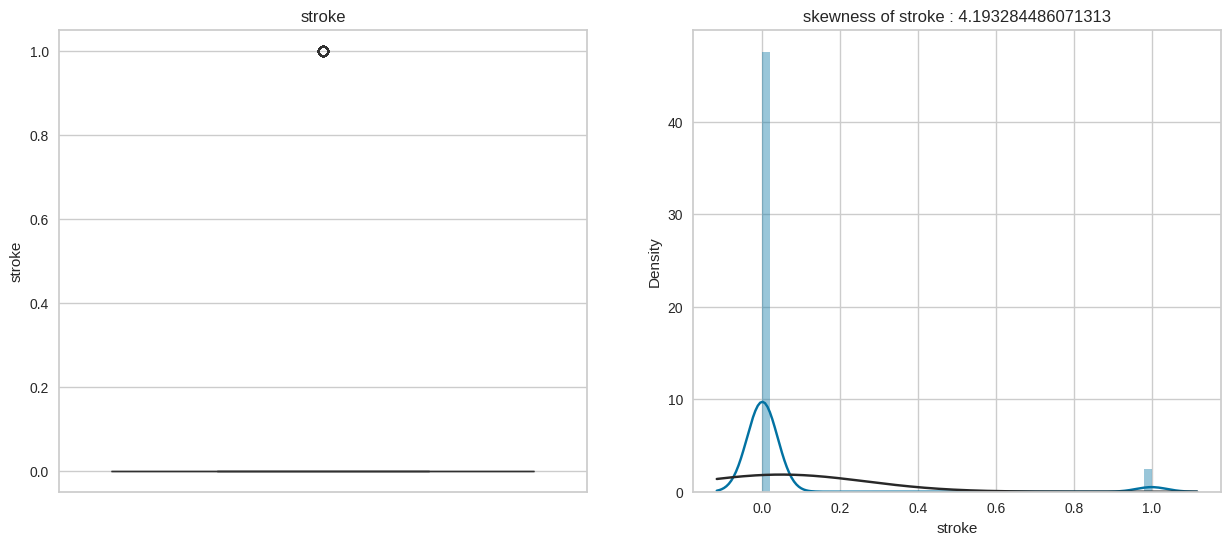

__________________________________________________________________________________________


In [25]:
# Importing library for checking normality in distribution
from scipy.stats import norm

# Plotting Box and Distribution plot using for loop
for var in numerical_variables:
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    ax=sns.boxplot(data=df[var])
    ax.set_title(f'{var}')
    ax.set_ylabel(var)

    plt.subplot(1,2,2)
    ax=sns.distplot(df[var], fit=norm)
    ax.set_title(f'skewness of {var} : {df[var].skew()}')
    ax.set_xlabel(var)
    print('__'*45)
    plt.show()
    print('__'*45)

In [26]:
# Capping dataset
for i in numerical_variables:
    # Findling IQR
    Q1=df[i].quantile(0.25)
    Q3=df[i].quantile(0.75)
    IQR=Q3-Q1

    # Defining upper and lower limit
    lower_limit =df[i].quantile(0.25)-1.5*IQR
    upper_limit =df[i].quantile(0.75)+1.5*IQR

    # Applying lower and upper limit to each variables
    df.loc[(df[i] > upper_limit),i] = upper_limit
    df.loc[(df[i] < lower_limit),i] = lower_limit

In [30]:
print(type_of_content)


work_type
Govt_job          657
Never_worked       22
Private          2925
Self-employed     819
children          687
dtype: int64


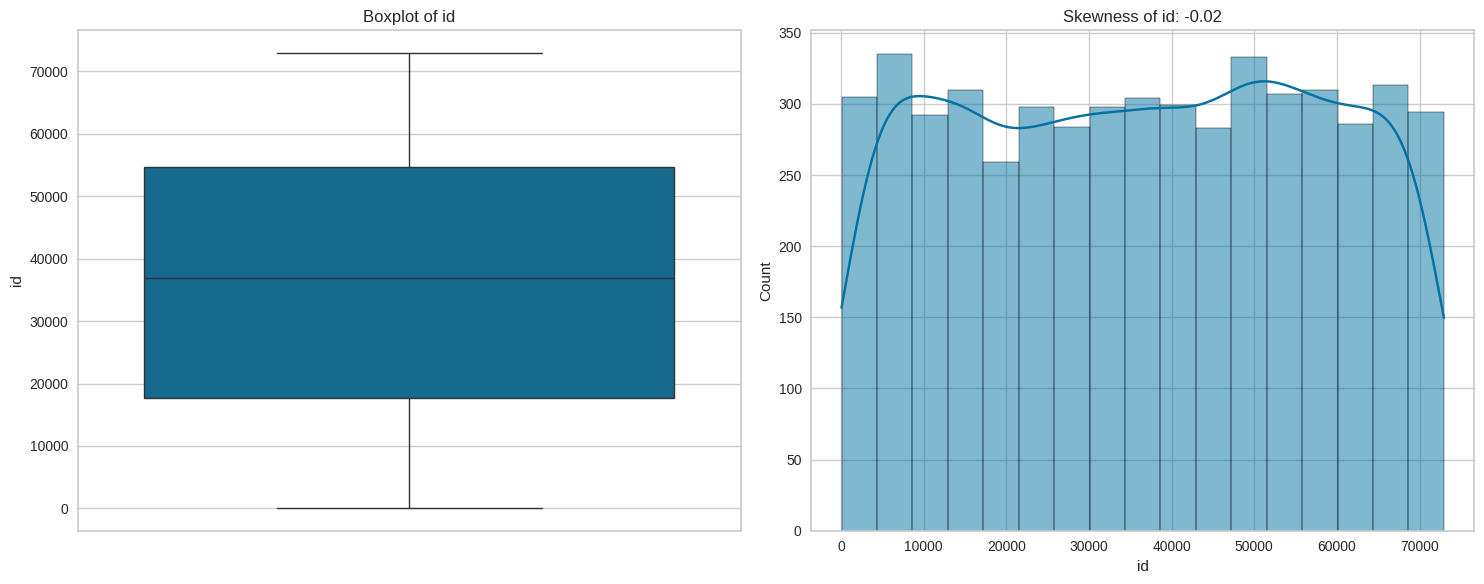

__________________________________________________________________________________________


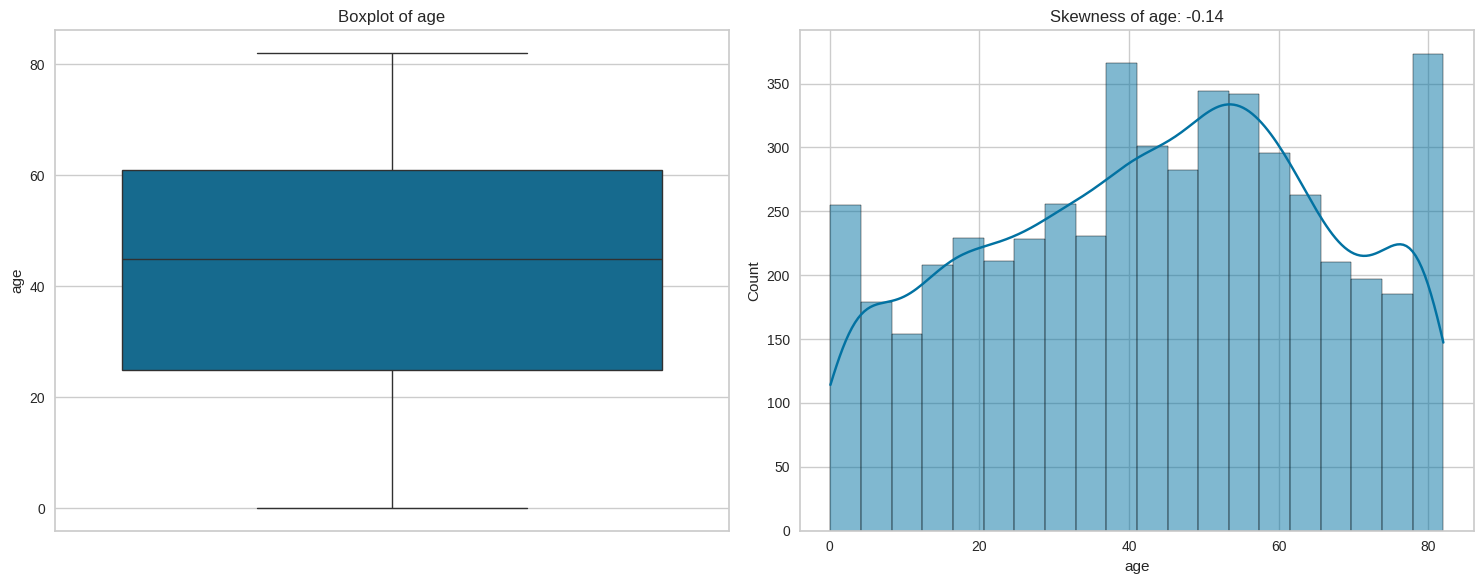

__________________________________________________________________________________________


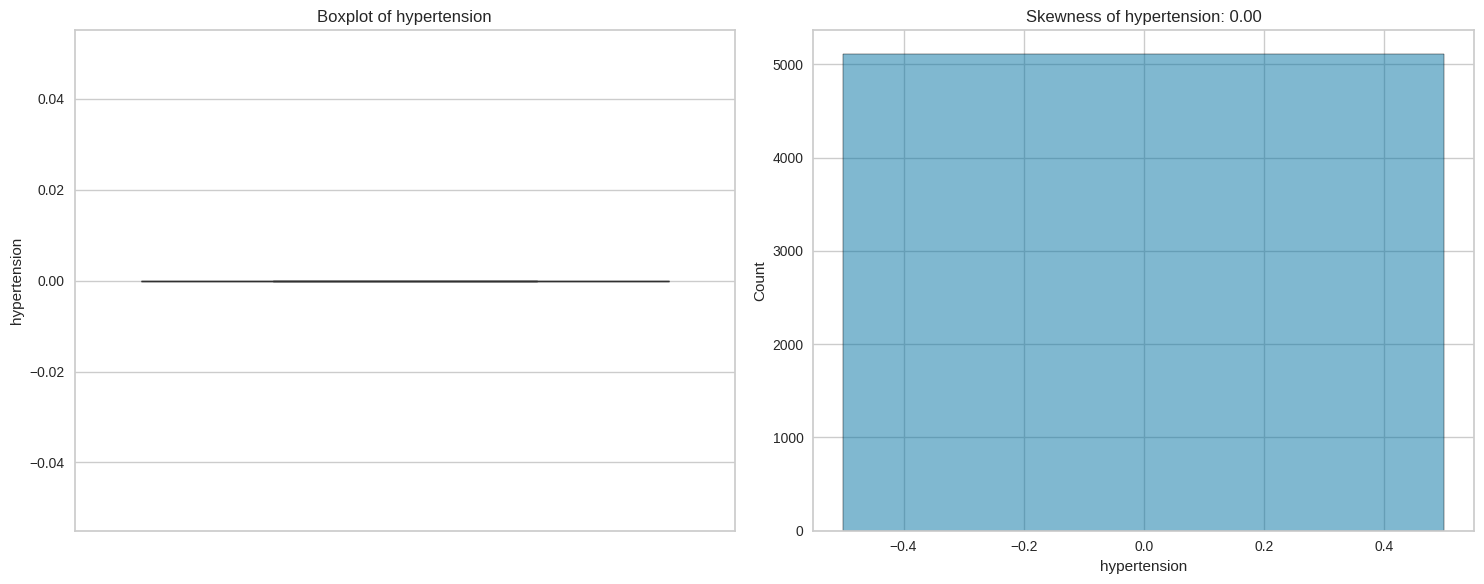

__________________________________________________________________________________________


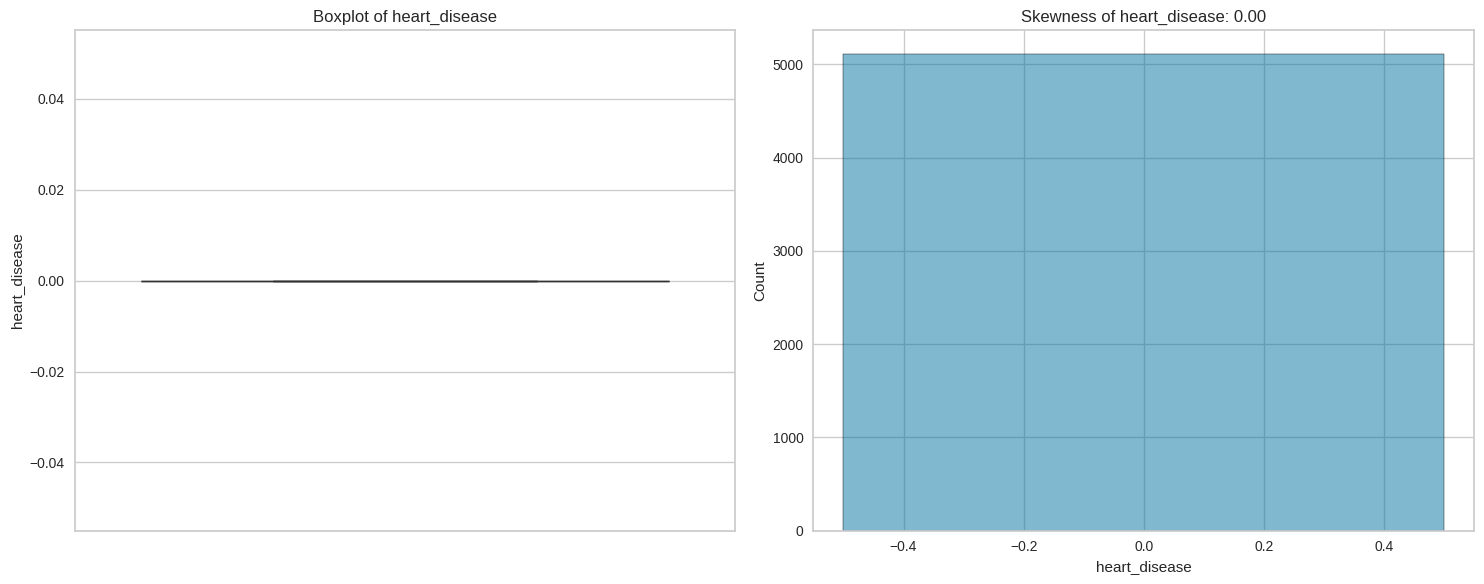

__________________________________________________________________________________________


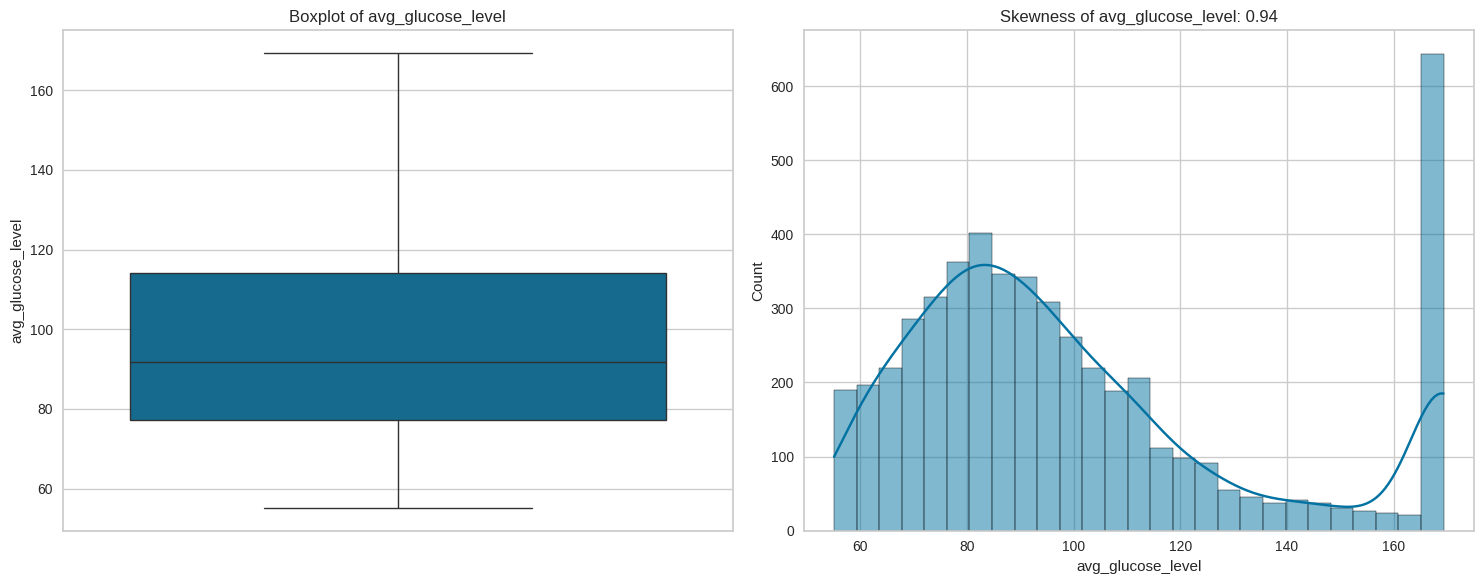

__________________________________________________________________________________________


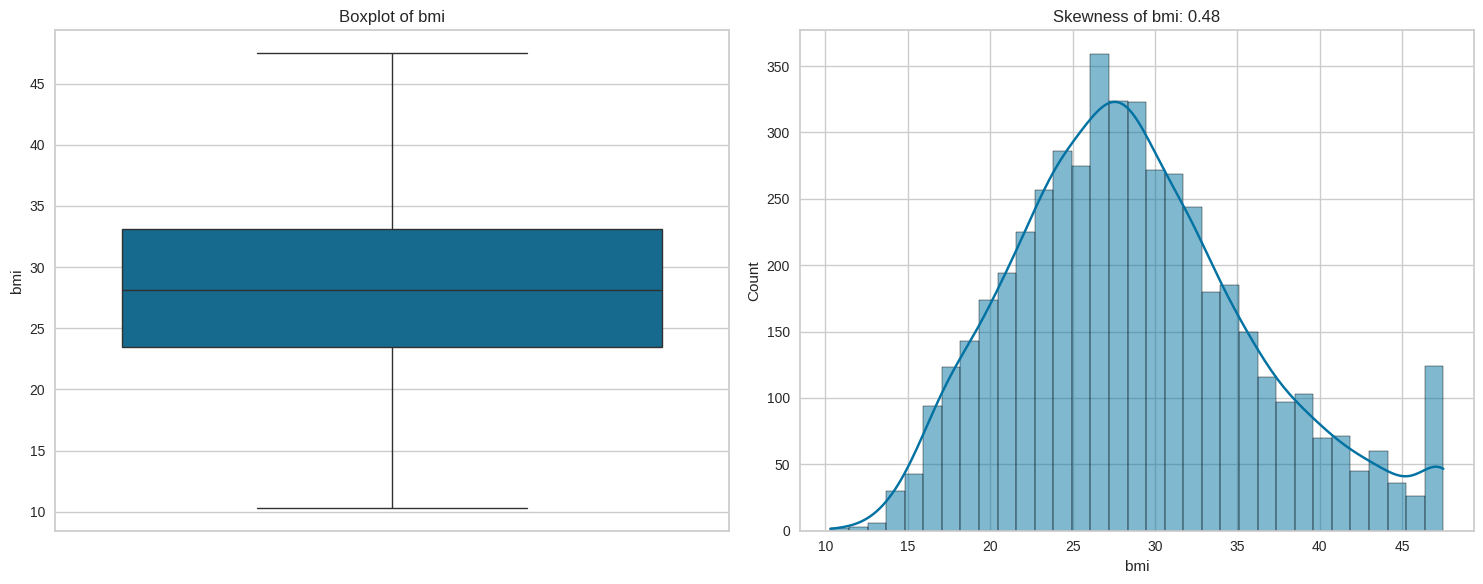

__________________________________________________________________________________________


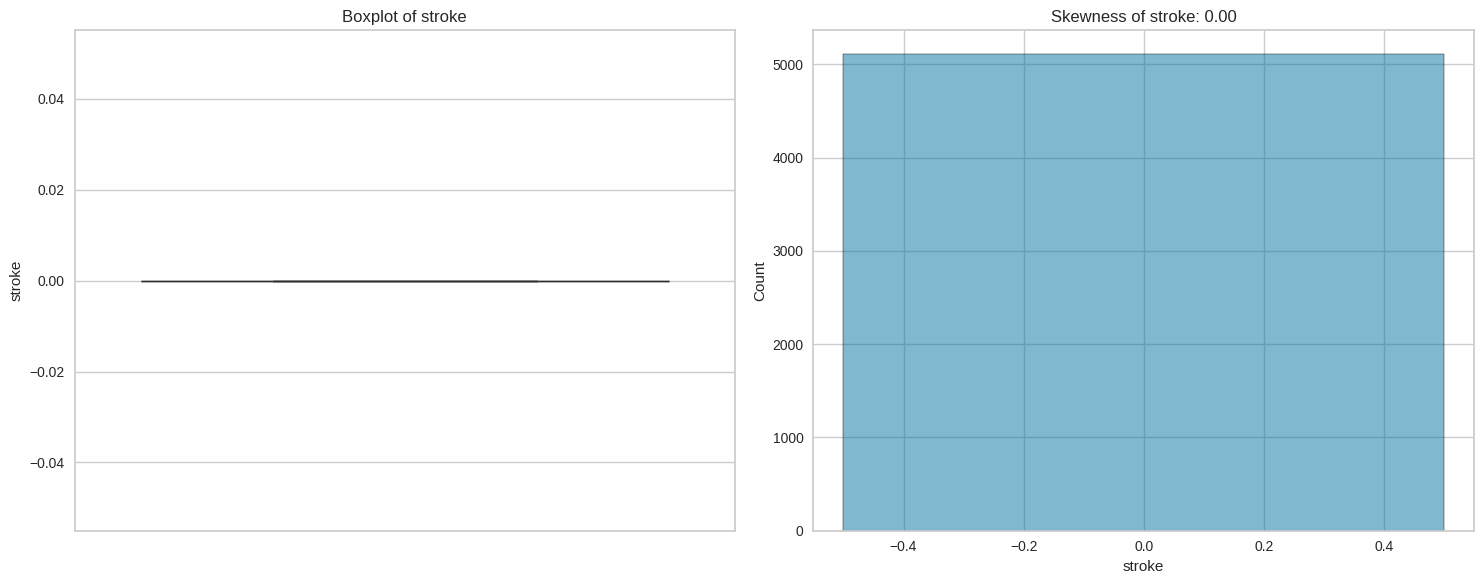

__________________________________________________________________________________________


In [35]:
## Using boxplot checking outliers in features after removed using IQR

for var in numerical_variables:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Boxplot
    sns.boxplot(data=df[var], ax=axes[0])
    axes[0].set_title(f'Boxplot of {var}')
    axes[0].set_ylabel(var)

    # Distribution plot with skewness
    sns.histplot(df[var], kde=True, ax=axes[1])
    axes[1].set_title(f'Skewness of {var}: {df[var].skew():.2f}')
    axes[1].set_xlabel(var)

    plt.tight_layout()
    plt.show()
    print('__' * 45)

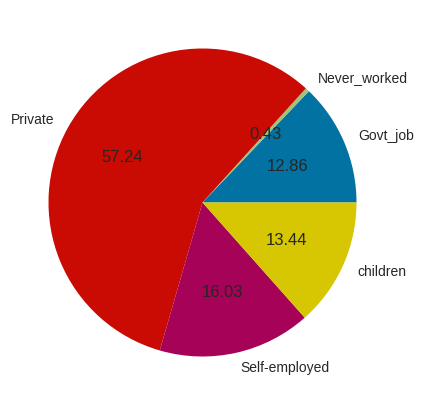

In [34]:
# Defining figure size
plt.figure(figsize=(5,5))

# Declaring data
type_of_content =df.groupby(by='work_type').size()

# Plotting data
plt.pie(type_of_content, labels=type_of_content.index, autopct='%.2f')

# Displaying chart
plt.show()

In [36]:
# Defining r to autofit the number and size of plots
r = int(len(df.columns))

In [37]:
# Defining a function to Notate the percent count of each value on the bars
def annot_percent(axes):
    '''Takes axes as input and labels the percent count of each bar in a countplot'''
    for p in plot.patches:
        total = sum(p.get_height() for p in plot.patches)/100
        percent = round((p.get_height()/total),2)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        plot.annotate(f'{percent}%', (x, y), ha='center', va='bottom')

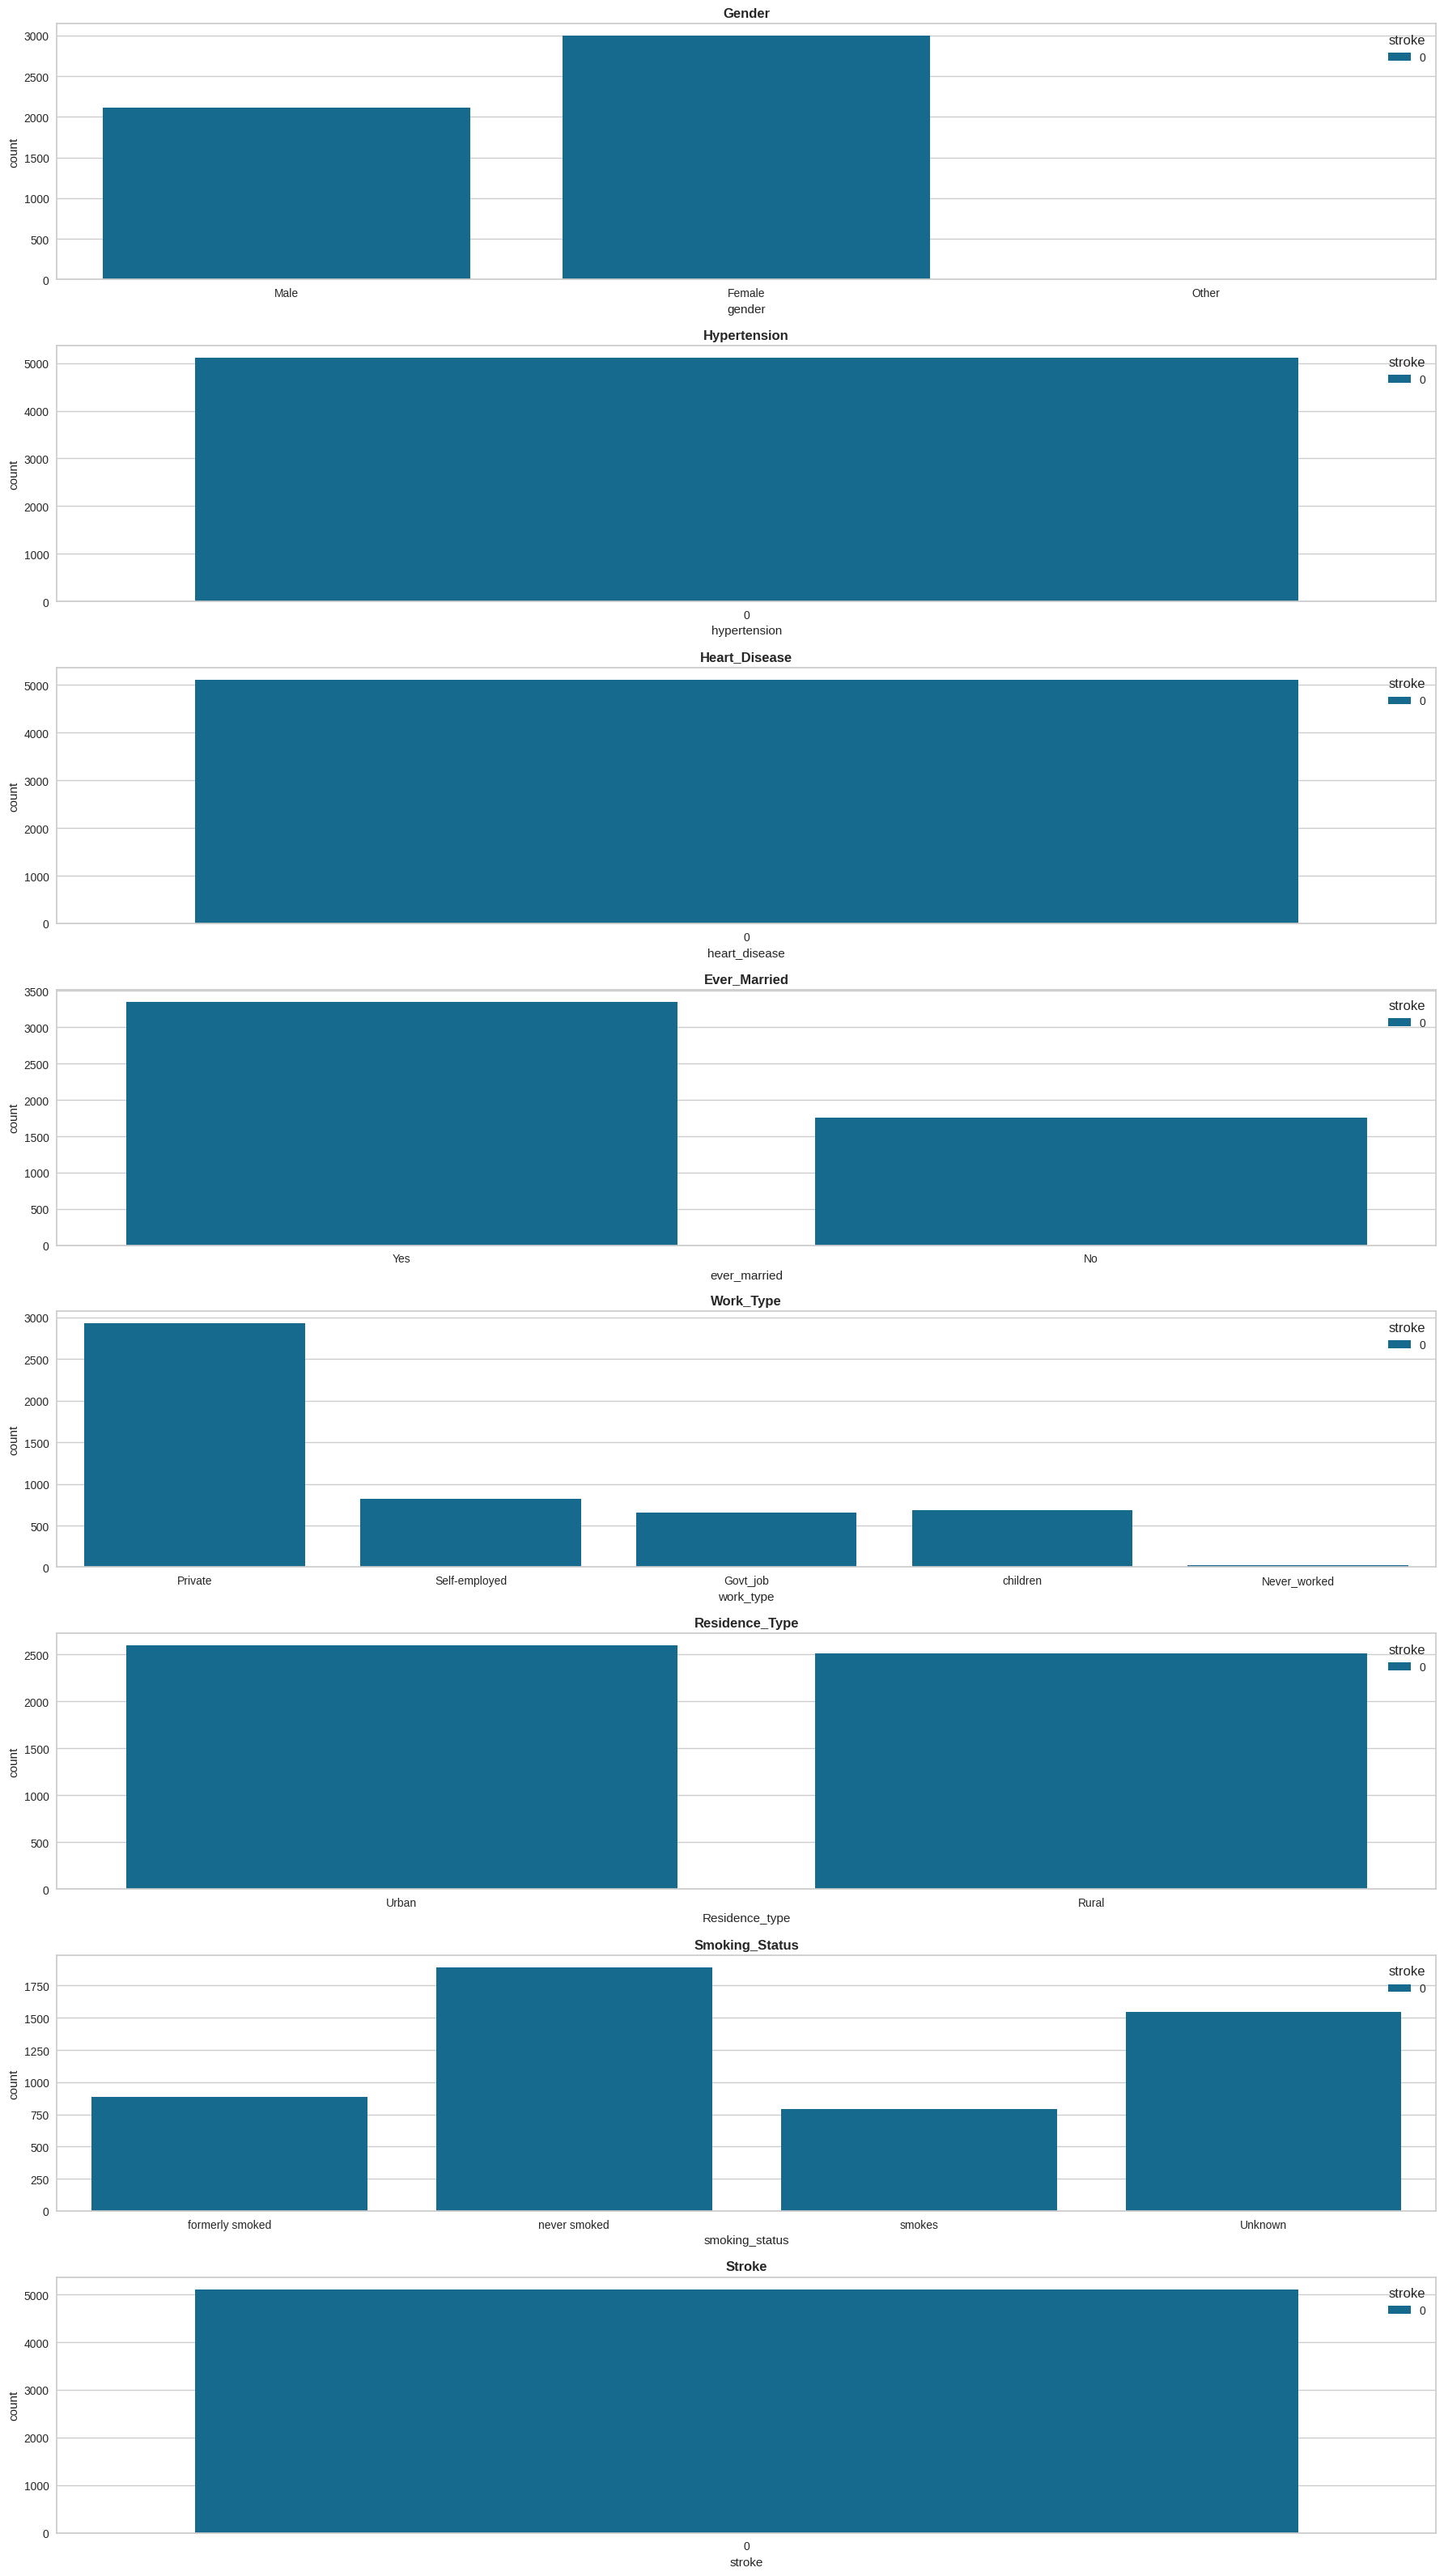

In [39]:
## Plotting the countplots for each variable in target_variables

target_var = [var for var in df.columns if df[var].nunique() < 20]

# Number of rows for subplots
r = len(target_var)

# Create subplots
fig, axes = plt.subplots(nrows=r, ncols=1, figsize=(18, r * 4))

for n, var in enumerate(target_var):
    ax = axes[n] if r > 1 else axes  # Handle single subplot case
    sns.countplot(x=df[var], hue=df['stroke'], ax=ax)  # Use 'stroke' as hue
    ax.set_title(f'{var.title()}', weight='bold')
    plt.tight_layout()

plt.show()

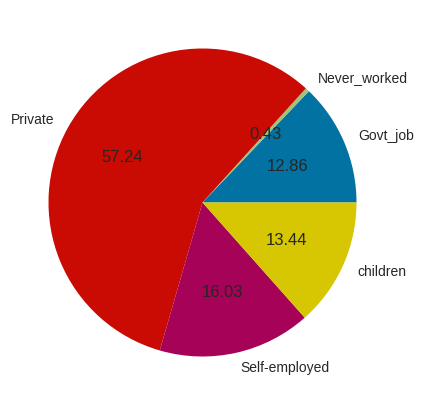

In [41]:
import matplotlib.pyplot as plt

# Ensure column names are cleaned
df.columns = df.columns.str.strip().str.lower()

# Check if the correct column exists
if 'work_type' in df.columns:
    # Group data by work type
    type_of_content = df.groupby(by='work_type').size()

    # Defining figure size
    plt.figure(figsize=(5, 5))

    # Plotting pie chart
    plt.pie(type_of_content, labels=type_of_content.index, autopct='%.2f')

    # Displaying chart
    plt.show()
else:
    print("Column 'work_type' not found in DataFrame. Check column names using df.columns")

